# PROYECTO REDCAFE

## VARIABLE DE SALIDA

In [3]:
#!pip install earthengine-api
#!pip install geemap
import ee
import geemap.core as geemap
import pandas as pd

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
ee.Authenticate()
ee.Initialize(project='ee-mpaulapolaniau')


In [5]:
# ------------------------
# 1. Definir regiones
# ------------------------

regiones = {
    "Sierra Nevada": ee.Geometry.Polygon([
        [
            [-74.6, 10.2],
            [-73.5, 10.2],
            [-73.5, 11.5],
            [-74.6, 11.5],
            [-74.6, 10.2]
        ]
    ]),
    "Caldas": ee.Geometry.Polygon([
        [
            [-76.2, 4.7],
            [-74.9, 4.7],
            [-74.9, 5.7],
            [-76.2, 5.7],
            [-76.2, 4.7]
        ]
    ])
}

In [6]:
# Colección MODIS NDVI
dataset = ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI')
#dataset = dataset.filterDate('2015-01-01', '2025-10-31')

In [7]:
# =========================
# 3. Función para obtener NDVI mensual REAL
# =========================

def ndvi_mensual(region_name, geometry, start="2015-01-01", end="2025-10-31"):
    fechas = ee.DateRange(start, end)
    start_date = ee.Date(start)
    end_date = ee.Date(end)

    meses = ee.List.sequence(
        start_date.difference(end_date, 'month').abs().toInt(),
        0, -1
    ).map(lambda i: start_date.advance(i, 'month'))

    registros = []

    for i in range(meses.size().getInfo()):
        inicio_mes = ee.Date(meses.get(i))
        fin_mes = inicio_mes.advance(1, 'month')

        # COMPOSICIÓN MENSUAL CORRECTA
        img_mensual = dataset.filterDate(inicio_mes, fin_mes).mean()

        # Reducir NDVI para toda la región
        val = img_mensual.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=250,
            maxPixels=1e13
        ).get('NDVI').getInfo()

        if val is not None:
            val = val * 0.0001

        mes_str = inicio_mes.format("YYYY-MM").getInfo()
        registros.append([region_name, mes_str, val])

    return pd.DataFrame(registros, columns=['Region', 'Mes', 'NDVI_mensual'])

In [8]:
# =========================
# 4. Obtener datos de ambas regiones
# =========================

dfs = []

for nombre, geom in regiones.items():
    df_region = ndvi_mensual(nombre, geom)
    dfs.append(df_region)

df_final = pd.concat(dfs).reset_index(drop=True)

df_final

,Region,Mes,NDVI_mensual
0,Sierra Nevada,2025-10,0.741886
1,Sierra Nevada,2025-09,0.773110
2,Sierra Nevada,2025-08,0.787096
3,Sierra Nevada,2025-07,0.762631
4,Sierra Nevada,2025-06,0.742989
...,...,...,...
255,Caldas,2015-05,0.604229
256,Caldas,2015-04,0.673003
257,Caldas,2015-03,0.551058
258,Caldas,2015-02,0.602596


In [9]:
# Guardar DataFrame como CSV
df_final.to_csv('ndvi_regiones.csv', index=False)

In [10]:
df_final["NDVI_en_rango"] = df_final["NDVI_mensual"].between(-1, 1)

print("✔ Cantidad de valores fuera del rango esperado (-1 a 1):")
print((~df_final["NDVI_en_rango"]).sum())

# Opcional: ver cuáles están fuera del rango
df_fuera_rango = df_final[~df_final["NDVI_en_rango"]]

✔ Cantidad de valores fuera del rango esperado (-1 a 1):
0


In [11]:
print("✔ Valores faltantes por columna:")
print(df_final.isna().sum())

✔ Valores faltantes por columna:
Region           0
Mes              0
NDVI_mensual     0
NDVI_en_rango    0
dtype: int64


In [12]:
# =======================================
# IQR por región para detectar outliers
# =======================================

# Calcular Q1, Q3 e IQR por región
iqr_df = df_final.groupby("Region")["NDVI_mensual"].agg(
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
)
iqr_df["IQR"] = iqr_df["Q3"] - iqr_df["Q1"]
iqr_df["lower"] = iqr_df["Q1"] - 1.5 * iqr_df["IQR"]
iqr_df["upper"] = iqr_df["Q3"] + 1.5 * iqr_df["IQR"]

# Unir de vuelta al dataframe original
df_final = df_final.merge(iqr_df, on="Region", how="left")

# Detectar outliers por región
df_final["Outlier"] = (
    (df_final["NDVI_mensual"] < df_final["lower"]) |
    (df_final["NDVI_mensual"] > df_final["upper"])
)

print("✔ Cantidad de outliers detectados por región:")
print(df_final.groupby("Region")["Outlier"].sum())

# Opcional: ver solo los outliers
df_outliers = df_final[df_final["Outlier"]]
df_outliers

✔ Cantidad de outliers detectados por región:
Region
Caldas           2
Sierra Nevada    1
Name: Outlier, dtype: int64


,Region,Mes,NDVI_mensual,NDVI_en_rango,Q1,Q3,IQR,lower,upper,Outlier
114,Sierra Nevada,2016-04,0.552740,True,0.665509,0.740176,0.074667,0.553509,0.852176,True
138,Caldas,2025-02,0.411145,True,0.573318,0.680264,0.106947,0.412898,0.840684,True
166,Caldas,2022-10,0.412798,True,0.573318,0.680264,0.106947,0.412898,0.840684,True


In [13]:
df_outliers

,Region,Mes,NDVI_mensual,NDVI_en_rango,Q1,Q3,IQR,lower,upper,Outlier
114,Sierra Nevada,2016-04,0.552740,True,0.665509,0.740176,0.074667,0.553509,0.852176,True
138,Caldas,2025-02,0.411145,True,0.573318,0.680264,0.106947,0.412898,0.840684,True
166,Caldas,2022-10,0.412798,True,0.573318,0.680264,0.106947,0.412898,0.840684,True


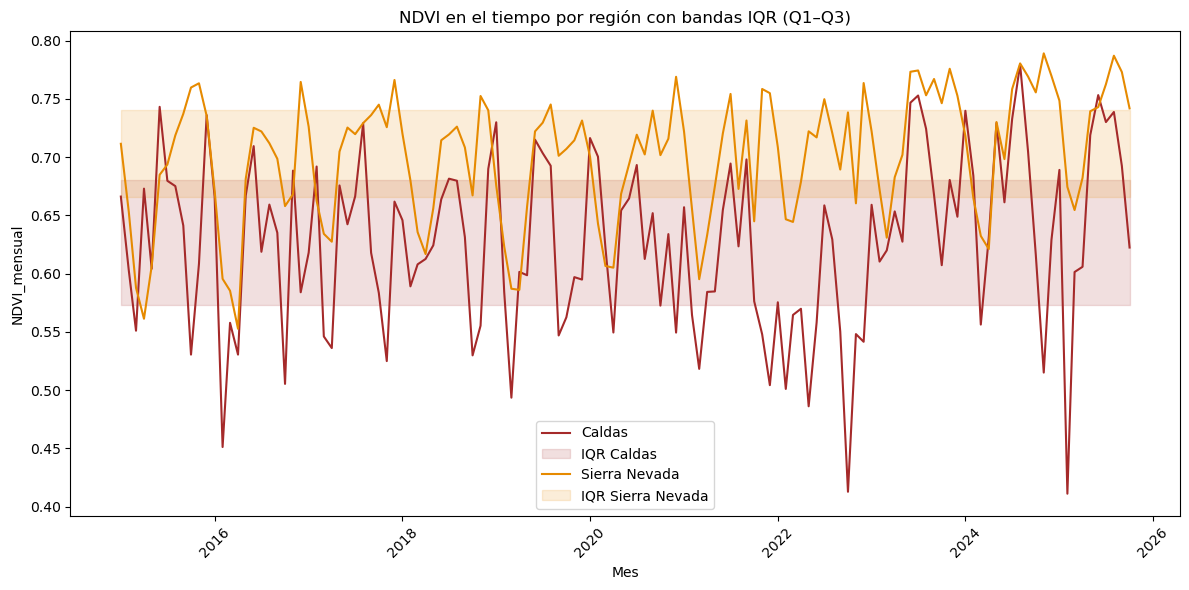

In [14]:
import matplotlib.pyplot as plt

# Convertir la columna Mes a datetime
df_final["Mes"] = pd.to_datetime(df_final["Mes"], format="%Y-%m")

# Ordenar por fecha
df_final_sorted = df_final.sort_values("Mes")

plt.figure(figsize=(12,6))

# =========================
#   Región: Caldas
# =========================
subset_caldas = df_final_sorted[df_final_sorted["Region"] == "Caldas"]

# Línea
plt.plot(
    subset_caldas["Mes"],
    subset_caldas["NDVI_mensual"],
    label="Caldas",
    color="#A52A2A"
)

# Banda Q1–Q3
plt.fill_between(
    subset_caldas["Mes"],
    subset_caldas["Q1"],
    subset_caldas["Q3"],
    color="#A52A2A",
    alpha=0.15,               # transparencia
    label="IQR Caldas"
)

# =========================
#   Región: Sierra Nevada
# =========================
subset_sierra = df_final_sorted[df_final_sorted["Region"] == "Sierra Nevada"]

# Línea
plt.plot(
    subset_sierra["Mes"],
    subset_sierra["NDVI_mensual"],
    label="Sierra Nevada",
    color="#E68A00"
)

# Banda Q1–Q3
plt.fill_between(
    subset_sierra["Mes"],
    subset_sierra["Q1"],
    subset_sierra["Q3"],
    color="#E68A00",
    alpha=0.15,
    label="IQR Sierra Nevada"
)

# =========================
# Configuración del gráfico
# =========================
plt.xlabel("Mes")
plt.ylabel("NDVI_mensual")
plt.title("NDVI en el tiempo por región con bandas IQR (Q1–Q3)")
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## VARIABLES DE ENTRADA

### EVAPOTRANSPIRACIÓN - EARTHDATA (GIOVANNI)

In [17]:
ds_caldas = xr.open_dataset("ETCaldas.nc")
ds_sierra = xr.open_dataset("ETSierra.nc")

df_ETcaldas = ds_caldas.to_dataframe().reset_index()
df_ETsierra = ds_sierra.to_dataframe().reset_index()

In [18]:
df_ETcaldas

,time,bnds,FLDAS_NOAH01_CP_GL_M_001_Evap_tavg,datamonth,time_bnds
0,2019-01-01,0,0.000048,201901,2019-01-01
1,2019-01-01,1,0.000048,201901,2019-02-01
2,2019-02-01,0,0.000047,201902,2019-02-01
3,2019-02-01,1,0.000047,201902,2019-03-01
4,2019-03-01,0,0.000049,201903,2019-03-01
...,...,...,...,...,...
159,2025-08-01,1,0.000048,202508,2025-09-01
160,2025-09-01,0,0.000046,202509,2025-09-01
161,2025-09-01,1,0.000046,202509,2025-10-01
162,2025-10-01,0,0.000042,202510,2025-10-01


In [19]:
#Cambiamos el nombre de la variable para un mejor manejo
varname = "FLDAS_NOAH01_CP_GL_M_001_Evap_tavg"
df_ETcaldas = df_ETcaldas.rename(columns={varname: "ET"})
df_ETsierra = df_ETsierra.rename(columns={varname: "ET"})

In [20]:
#convetirmos la variable a mm/mes
def convert_to_mm_monthly(df, variable):
    df['days'] = df['time'].dt.days_in_month
    df['ET_mm'] = df[variable] * 60 * 60 * 24 * df['days']
    return df

df_ETcaldas = convert_to_mm_monthly(df_ETcaldas, "ET")
df_ETsierra = convert_to_mm_monthly(df_ETsierra, "ET")

In [21]:
df_ETcaldas

,time,bnds,ET,datamonth,time_bnds,days,ET_mm
0,2019-01-01,0,0.000048,201901,2019-01-01,31,128.217202
1,2019-01-01,1,0.000048,201901,2019-02-01,31,128.217202
2,2019-02-01,0,0.000047,201902,2019-02-01,28,113.268881
3,2019-02-01,1,0.000047,201902,2019-03-01,28,113.268881
4,2019-03-01,0,0.000049,201903,2019-03-01,31,131.254745
...,...,...,...,...,...,...,...
159,2025-08-01,1,0.000048,202508,2025-09-01,31,129.464208
160,2025-09-01,0,0.000046,202509,2025-09-01,30,119.592304
161,2025-09-01,1,0.000046,202509,2025-10-01,30,119.592304
162,2025-10-01,0,0.000042,202510,2025-10-01,31,111.657277


In [22]:
#Eliminamos las variables 'bnds' y 'time_bnds', ya que no representan información adicional y solo marcan el inicio y el final del mes
df_ETcaldas = df_ETcaldas.drop(columns=['bnds', 'time_bnds'])
df_ETsierra = df_ETsierra.drop(columns=['bnds', 'time_bnds'])

In [23]:
#Creamos una función para hacer un análisis rápido de cada dataset
def quality_report(df, name="Dataset"):
    print(f"\n REPORTE DE CALIDAD: {name}\n")
    print(f"Total de filas: {len(df)}")
    #calculo de duplicados totales
    full_dups = df.duplicated().sum()
    print(f"Filas duplicadas completas: {full_dups}")
    #Calculamos los duplicados de la columna fecha, para validar que no existan más de dos registros para un periodo
    if 'time' in df.columns:
        time_dups = df.duplicated(subset=['time']).sum()
        print(f"Duplicados en la columna 'time': {time_dups}")
    else:
        print("⚠ La columna 'time' no existe en el dataframe.")
    #Nulos por columna
    print("\nValores nulos por columna:")
    print(df.isna().sum())
    #Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes)
    #Rango de fechas
    if 'time' in df.columns:
        print("\nRango de fechas:")
        print(f"Fecha mínima: {df['time'].min()}")
        print(f"Fecha máxima: {df['time'].max()}")
    else:
        print("\nNo se puede medir el rango de fechas (falta columna time).")
    #Estadísticas básicas de ET
    if 'ET' in df.columns:
        print("\nEstadísticas de la variable ET:")
        print(df['ET_mm'].describe())
    else:
        print("\n⚠ La columna no existe.")

In [24]:
quality_report(df_ETcaldas, name="ET Caldas")


 REPORTE DE CALIDAD: ET Caldas

Total de filas: 164
Filas duplicadas completas: 82
Duplicados en la columna 'time': 82

Valores nulos por columna:
time         0
ET           0
datamonth    0
days         0
ET_mm        0
dtype: int64

Tipos de datos:
time         datetime64[ns]
ET                  float32
datamonth             int32
days                  int32
ET_mm               float64
dtype: object

Rango de fechas:
Fecha mínima: 2019-01-01 00:00:00
Fecha máxima: 2025-10-01 00:00:00

Estadísticas de la variable ET:
count    164.000000
mean     119.486938
std       11.016650
min       92.511513
25%      112.354364
50%      120.028845
75%      128.350139
max      138.610082
Name: ET_mm, dtype: float64


In [25]:
quality_report(df_ETsierra, name="ET Sierra")


 REPORTE DE CALIDAD: ET Sierra

Total de filas: 164
Filas duplicadas completas: 82
Duplicados en la columna 'time': 82

Valores nulos por columna:
time         0
ET           0
datamonth    0
days         0
ET_mm        0
dtype: int64

Tipos de datos:
time         datetime64[ns]
ET                  float32
datamonth             int32
days                  int32
ET_mm               float64
dtype: object

Rango de fechas:
Fecha mínima: 2019-01-01 00:00:00
Fecha máxima: 2025-10-01 00:00:00

Estadísticas de la variable ET:
count    164.000000
mean      91.968947
std       29.333543
min       29.766069
25%       67.294343
50%      101.490868
75%      115.521641
max      135.827646
Name: ET_mm, dtype: float64


In [26]:
#Teniendo en cuenta que no hay variables nulas, eliminamos duplicados
df_ETcaldas = df_ETcaldas.drop_duplicates(subset=['time'])
df_ETsierra = df_ETsierra.drop_duplicates(subset=['time'])

df_ETcaldas.shape


(82, 5)

In [27]:
df_ETsierra.shape

(82, 5)

In [28]:
#Por último eliminamos las columnas que no necesitaremos más adelante, para dejar el dataset más limpio
df_ETcaldas = df_ETcaldas.drop(columns=['datamonth', 'days'])
df_ETsierra = df_ETsierra.drop(columns=['datamonth', 'days'])

df_ETcaldas = df_ETcaldas.sort_values('time').reset_index(drop=True)
df_ETsierra = df_ETsierra.sort_values('time').reset_index(drop=True)

In [29]:
df_ETcaldas.head()
df_ETcaldas.tail()

df_ETsierra.head()
df_ETsierra.tail()


,time,ET,ET_mm
77,2025-06-01,0.000043,110.367944
78,2025-07-01,0.000046,123.828219
79,2025-08-01,0.000048,128.236123
80,2025-09-01,0.000045,116.883094
81,2025-10-01,0.000043,114.774466


In [30]:
df_ETcaldas.isna().sum()
#df_ETsierra.isna().sum()

time     0
ET       0
ET_mm    0
dtype: int64

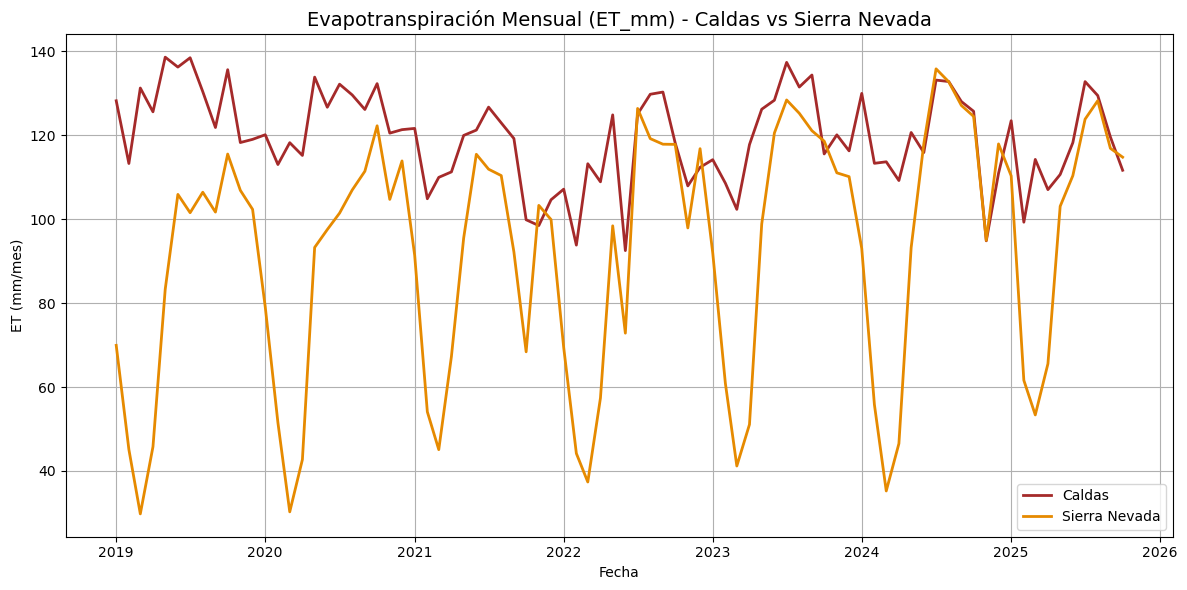

In [31]:
#Comparamos la evapotranspiración mensual de las dos zonas
plt.figure(figsize=(12,6))

plt.plot(df_ETcaldas['time'], df_ETcaldas['ET_mm'], label='Caldas', linewidth=2, color='#A52A2A')
plt.plot(df_ETsierra['time'], df_ETsierra['ET_mm'], label='Sierra Nevada', linewidth=2, color='#E68A00')

plt.title('Evapotranspiración Mensual (ET_mm) - Caldas vs Sierra Nevada', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('ET (mm/mes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
#Identificamos los meses secos y los meses húmedos en Caldas
p25_caldas = df_ETcaldas['ET_mm'].quantile(0.25)
p75_caldas = df_ETcaldas['ET_mm'].quantile(0.75)

df_ETcaldas['clima_mes'] = df_ETcaldas['ET_mm'].apply(
    lambda x: 'Seco' if x < p25_caldas else
              'Húmedo' if x > p75_caldas else
              'Normal'
)

df_ETcaldas[['time','ET_mm','clima_mes']].head(15)

,time,ET_mm,clima_mes
0,2019-01-01,128.217202,Normal
1,2019-02-01,113.268881,Normal
2,2019-03-01,131.254745,Húmedo
3,2019-04-01,125.582457,Normal
4,2019-05-01,138.610082,Húmedo
5,2019-06-01,136.248465,Húmedo
6,2019-07-01,138.470999,Húmedo
7,2019-08-01,130.390326,Húmedo
8,2019-09-01,121.849122,Normal
9,2019-10-01,135.622591,Húmedo


In [33]:
#Identificamos los meses secos y los meses húmedos en la Sierra
p25_sierra = df_ETsierra['ET_mm'].quantile(0.25)
p75_sierra = df_ETsierra['ET_mm'].quantile(0.75)

df_ETsierra['clima_mes'] = df_ETsierra['ET_mm'].apply(
    lambda x: 'Seco' if x < p25_sierra else
              'Húmedo' if x > p75_sierra else
              'Normal'
)

df_ETsierra[['time','ET_mm','clima_mes']].head(15)

,time,ET_mm,clima_mes
0,2019-01-01,69.926548,Normal
1,2019-02-01,45.117358,Seco
2,2019-03-01,29.766069,Seco
3,2019-04-01,45.771368,Seco
4,2019-05-01,83.296321,Normal
5,2019-06-01,105.907967,Normal
6,2019-07-01,101.541012,Normal
7,2019-08-01,106.425723,Normal
8,2019-09-01,101.688609,Normal
9,2019-10-01,115.521641,Húmedo


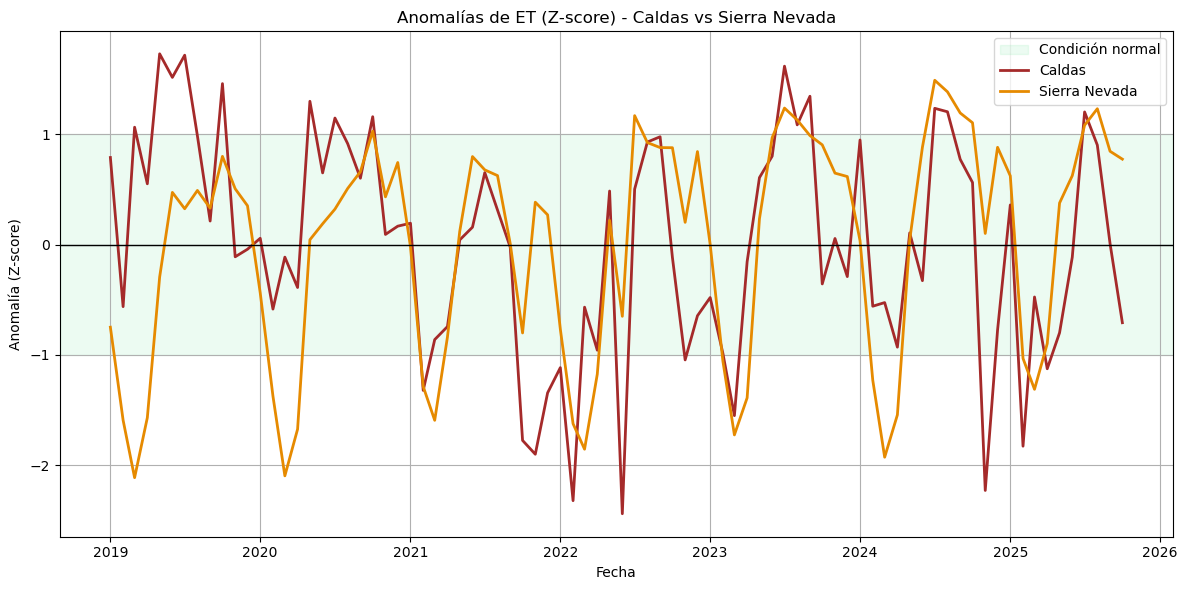

In [34]:
#a partir de lo anterior calculamos los meses con anomalías climáticas
df_ETcaldas['ET_anom'] = (df_ETcaldas['ET_mm'] - df_ETcaldas['ET_mm'].mean()) / df_ETcaldas['ET_mm'].std()
df_ETsierra['ET_anom']  = (df_ETsierra['ET_mm'] - df_ETsierra['ET_mm'].mean()) / df_ETsierra['ET_mm'].std()

plt.figure(figsize=(12,6))
plt.axhspan(-1, 1, color='#4ADE80', alpha=0.10, label='Condición normal')
plt.plot(df_ETcaldas['time'], df_ETcaldas['ET_anom'], label='Caldas', linewidth=2, color='#A52A2A')
plt.plot(df_ETsierra['time'], df_ETsierra['ET_anom'], label='Sierra Nevada', linewidth=2, color='#E68A00')
plt.axhline(0, color='black', linewidth=1)

plt.title('Anomalías de ET (Z-score) - Caldas vs Sierra Nevada')
plt.xlabel('Fecha')
plt.ylabel('Anomalía (Z-score)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### TEMPERATURA SUPERFICIAL DEL SUELO

In [36]:
ds_caldas = xr.open_dataset("TemperauraSuperficialSueloCaldas.nc")
ds_sierra = xr.open_dataset("TemperaturaSuperficialSueloSierra.nc")

df_TScaldas = ds_caldas.to_dataframe().reset_index()
df_TSsierra = ds_sierra.to_dataframe().reset_index()

In [37]:
df_TScaldas

,time,bnds,GLDAS_NOAH10_M_2_1_AvgSurfT_inst,datamonth,time_bnds
0,2015-01-01,0,290.615631,201501,2015-01-01
1,2015-01-01,1,290.615631,201501,2015-02-01
2,2015-02-01,0,291.294617,201502,2015-02-01
3,2015-02-01,1,291.294617,201502,2015-03-01
4,2015-03-01,0,291.690796,201503,2015-03-01
...,...,...,...,...,...
247,2025-04-01,1,291.522614,202504,2025-05-01
248,2025-05-01,0,291.290070,202505,2025-05-01
249,2025-05-01,1,291.290070,202505,2025-06-01
250,2025-06-01,0,290.713898,202506,2025-06-01


In [38]:
df_TSsierra

,time,bnds,GLDAS_NOAH10_M_2_1_AvgSurfT_inst,datamonth,time_bnds
0,2015-01-01,0,298.237366,201501,2015-01-01
1,2015-01-01,1,298.237366,201501,2015-02-01
2,2015-02-01,0,300.549286,201502,2015-02-01
3,2015-02-01,1,300.549286,201502,2015-03-01
4,2015-03-01,0,301.899353,201503,2015-03-01
...,...,...,...,...,...
247,2025-04-01,1,299.914612,202504,2025-05-01
248,2025-05-01,0,298.325989,202505,2025-05-01
249,2025-05-01,1,298.325989,202505,2025-06-01
250,2025-06-01,0,298.118073,202506,2025-06-01


In [39]:
# Cambiamos el nombre de la variable para un mejor manejo ---
varname = "GLDAS_NOAH10_M_2_1_AvgSurfT_inst"
df_TScaldas = df_TScaldas.rename(columns={varname: "TS"})
df_TSsierra = df_TSsierra.rename(columns={varname: "TS"})

In [40]:
# ================================================
# Conversión de Temperatura Superficial del Suelo (K → °C)
# y cálculo de promedios mensuales para Caldas y Sierra Nevada
# ================================================

import pandas as pd
import matplotlib.pyplot as plt

# Convertimos TS de Kelvin a °C ---
def convert_to_celsius(df, variable):
    df['TS_C'] = df[variable] - 273.15
    return df

df_TScaldas = convert_to_celsius(df_TScaldas, "TS")
df_TSsierra = convert_to_celsius(df_TSsierra, "TS")

In [41]:
#Eliminamos las variables 'bnds' y 'time_bnds', ya que no representan información adicional y solo marcan el inicio y el final del mes
df_TScaldas = df_TScaldas.drop(columns=['bnds', 'time_bnds', 'datamonth'])
df_TSsierra = df_TSsierra.drop(columns=['bnds', 'time_bnds', 'datamonth'])

In [42]:
df_TScaldas = df_TScaldas.drop_duplicates(subset=['time'])
df_TSsierra = df_TSsierra.drop_duplicates(subset=['time'])

In [49]:
df_TSsierra

,time,TS,TS_C
0,2015-01-01,298.237366,25.087372
2,2015-02-01,300.549286,27.399292
4,2015-03-01,301.899353,28.749359
6,2015-04-01,300.862122,27.712128
8,2015-05-01,300.765656,27.615662
...,...,...,...
242,2025-02-01,299.867249,26.717255
244,2025-03-01,301.217499,28.067505
246,2025-04-01,299.914612,26.764618
248,2025-05-01,298.325989,25.175995


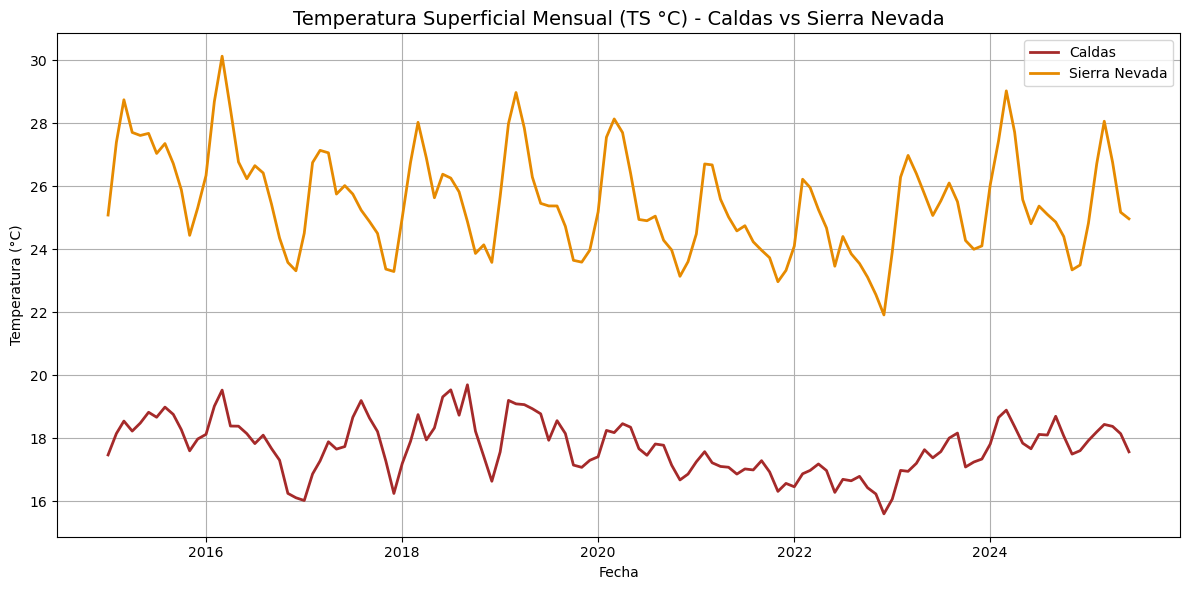

In [56]:
#Comparamos la evapotranspiración mensual de las dos zonas
plt.figure(figsize=(12,6))

plt.plot(df_TScaldas['time'], df_TScaldas['TS_C'], label='Caldas', linewidth=2, color='#A52A2A')
plt.plot(df_TSsierra['time'], df_TSsierra['TS_C'], label='Sierra Nevada', linewidth=2, color='#E68A00')

plt.title('Temperatura Superficial Mensual (TS °C) - Caldas vs Sierra Nevada', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# ===========================================================
# CLASIFICACIÓN DE MESES SEGÚN TEMPERATURA SUPERFICIAL (TS)
# Caldas y Sierra Nevada
# ===========================================================

# Cuartiles (percentiles 25 y 75) para definir umbrales
p25_caldas = df_TScaldas['TS_C'].quantile(0.25)
p75_caldas = df_TSsierra['TS_C'].quantile(0.75)

p25_sierra = df_TScaldas['TS_C'].quantile(0.25)
p75_sierra = df_TSsierra['TS_C'].quantile(0.75)

# Clasificamos los meses según su temperatura
df_TScaldas['clima_mes'] = df_TScaldas['TS_C'].apply(
    lambda x: 'Frío' if x < p25_caldas else ('Cálido' if x > p75_caldas else 'Normal')
)

df_TSsierra['clima_mes'] = df_TSsierra['TS_C'].apply(
    lambda x: 'Frío' if x < p25_sierra else ('Cálido' if x > p75_sierra else 'Normal')
)

df_TSsierra

,time,TS,TS_C,clima_mes
0,2015-01-01,298.237366,25.087372,Normal
2,2015-02-01,300.549286,27.399292,Cálido
4,2015-03-01,301.899353,28.749359,Cálido
6,2015-04-01,300.862122,27.712128,Cálido
8,2015-05-01,300.765656,27.615662,Cálido
...,...,...,...,...
242,2025-02-01,299.867249,26.717255,Cálido
244,2025-03-01,301.217499,28.067505,Cálido
246,2025-04-01,299.914612,26.764618,Cálido
248,2025-05-01,298.325989,25.175995,Normal


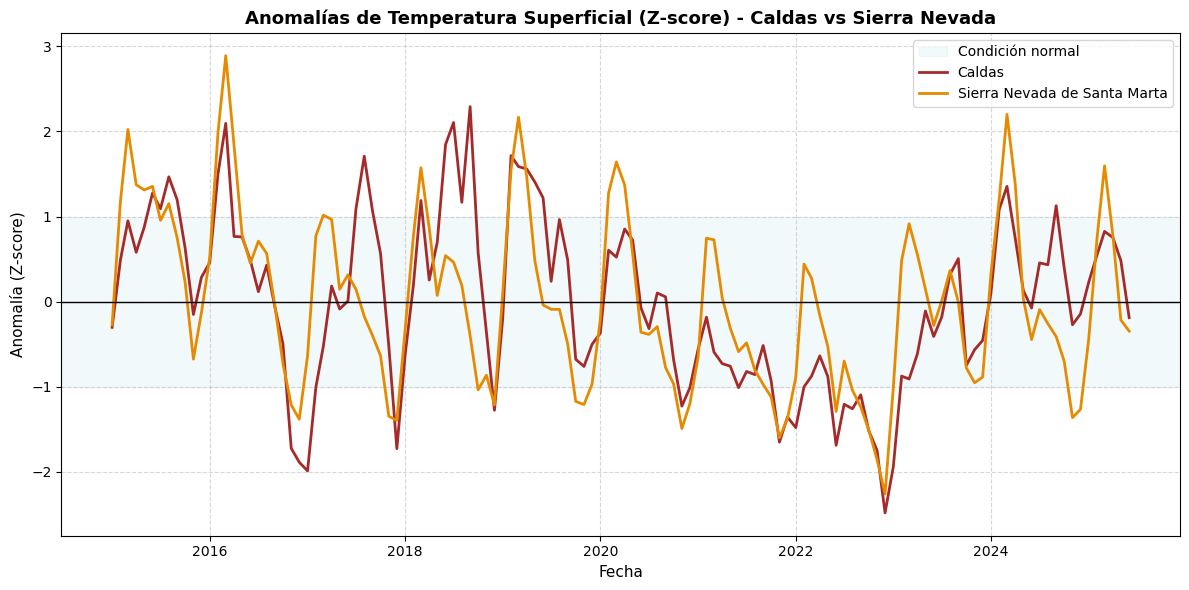

In [68]:
# ======================================================
# ANOMALÍAS DE TEMPERATURA SUPERFICIAL DEL SUELO (TS)
# Caldas vs Sierra Nevada de Santa Marta
# ======================================================

import matplotlib.pyplot as plt

# Calculamos anomalías (Z-score)
df_TScaldas['TS_anom'] = (
    df_TScaldas['TS_C'] - df_TScaldas['TS_C'].mean()
) / df_TScaldas['TS_C'].std()

df_TSsierra['TS_anom'] = (
    df_TSsierra['TS_C'] - df_TSsierra['TS_C'].mean()
) / df_TSsierra['TS_C'].std()

# Graficamos 
plt.figure(figsize=(12,6))

# Franja sombreada para condiciones normales
plt.axhspan(-1, 1, color='#ADD8E6', alpha=0.15, label='Condición normal')

# Curvas de anomalías
plt.plot(df_TScaldas['time'], df_TScaldas['TS_anom'],
         label='Caldas', color='#A52A2A', linewidth=2)
plt.plot(df_TSsierra['time'], df_TSsierra['TS_anom'],
         label='Sierra Nevada de Santa Marta', color='#E68A00', linewidth=2)

# Línea base (anomalía cero)
plt.axhline(0, color='black', linewidth=1)

# --- 3. Estilo del gráfico ---
plt.title('Anomalías de Temperatura Superficial (Z-score) - Caldas vs Sierra Nevada',
          fontsize=13, fontweight='bold')
plt.xlabel('Fecha', fontsize=11)
plt.ylabel('Anomalía (Z-score)', fontsize=11)

plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### UNIÓN DE DATAFRAMES

In [74]:
df_NVDICaldas = df_final[df_final['Region'] == 'Caldas'].copy()
df_NVDISierra = df_final[df_final['Region'] == 'Sierra Nevada'].copy()


In [75]:
df_NVDICaldas = df_NVDICaldas.drop(
    ["Region", "NDVI_en_rango", "Q1", "Q3", "IQR", "lower", "upper", "Outlier"], 
    axis=1
)
df_NVDICaldas = df_NVDICaldas.reset_index(drop=True)

#df_NVDICaldas

In [76]:
df_NVDICaldas = df_NVDICaldas.rename(columns={"Mes": "time"})
df_NVDISierra = df_NVDISierra.rename(columns={"Mes": "time"})

In [77]:
df_NVDISierra = df_NVDISierra.drop(
    ["Region", "NDVI_en_rango", "Q1", "Q3", "IQR", "lower", "upper", "Outlier"], 
    axis=1
)
df_NVDISierra = df_NVDISierra.reset_index(drop=True)

#df_NVDISierra

In [78]:
df_ETsierra = df_ETsierra.drop(
    ['ET', 'clima_mes', 'ET_anom'], 
    axis=1
) 

In [79]:
df_ETcaldas = df_ETcaldas.drop(
    ['ET', 'clima_mes', 'ET_anom'], 
    axis=1
) 

In [80]:
df_TScaldas.columns


Index(['time', 'TS', 'TS_C', 'clima_mes', 'TS_anom'], dtype='object')

In [81]:
df_TScaldas = df_TScaldas.drop(
    ['TS', 'clima_mes', 'TS_anom'], 
    axis=1
) 


In [82]:
df_TSsierra = df_TSsierra.drop(
    ['TS', 'clima_mes', 'TS_anom'], 
    axis=1
) 

In [83]:
print(df_NVDICaldas.shape)
print(df_ETcaldas.shape)
print(df_TScaldas.shape)

(130, 2)
(82, 2)
(126, 2)


In [84]:
df_NVDICaldas['time'] = pd.to_datetime(df_NVDICaldas['time'])
df_ETcaldas['time'] = pd.to_datetime(df_ETcaldas['time'])
df_TScaldas['time'] = pd.to_datetime(df_TScaldas['time'])
df_NVDISierra['time'] = pd.to_datetime(df_NVDISierra['time'])
df_ETsierra['time'] = pd.to_datetime(df_ETsierra['time'])
df_TSsierra['time'] = pd.to_datetime(df_TSsierra['time'])


In [85]:
df_caldas_union = (
    df_NVDICaldas
        .merge(df_ETcaldas, on="time", how="outer")
        .merge(df_TScaldas, on="time", how="outer")
)
df_caldas_union

,time,NDVI_mensual,ET_mm,TS_C
0,2015-01-01,0.666199,NaN,17.465637
1,2015-02-01,0.602596,NaN,18.144623
2,2015-03-01,0.551058,NaN,18.540802
3,2015-04-01,0.673003,NaN,18.223419
4,2015-05-01,0.604229,NaN,18.476868
...,...,...,...,...
125,2025-06-01,0.753294,118.231409,17.563904
126,2025-07-01,0.730144,132.783465,NaN
127,2025-08-01,0.738806,129.464208,NaN
128,2025-09-01,0.692530,119.592304,NaN


In [86]:
df_sierra_union = (
    df_NVDISierra
        .merge(df_ETsierra, on="time", how="outer")
        .merge(df_TSsierra, on="time", how="outer")
)
df_sierra_union

,time,NDVI_mensual,ET_mm,TS_C
0,2015-01-01,0.711496,NaN,25.087372
1,2015-02-01,0.652867,NaN,27.399292
2,2015-03-01,0.587869,NaN,28.749359
3,2015-04-01,0.561308,NaN,27.712128
4,2015-05-01,0.606579,NaN,27.615662
...,...,...,...,...
125,2025-06-01,0.742989,110.367944,24.968079
126,2025-07-01,0.762631,123.828219,NaN
127,2025-08-01,0.787096,128.236123,NaN
128,2025-09-01,0.773110,116.883094,NaN


In [87]:
corr_matrixC = df_caldas_union.corr(numeric_only=True).sort_values(by='ET_mm')
corr_matrixC

,NDVI_mensual,ET_mm,TS_C
TS_C,0.170200,0.335553,1.000000
NDVI_mensual,1.000000,0.512361,0.170200
ET_mm,0.512361,1.000000,0.335553


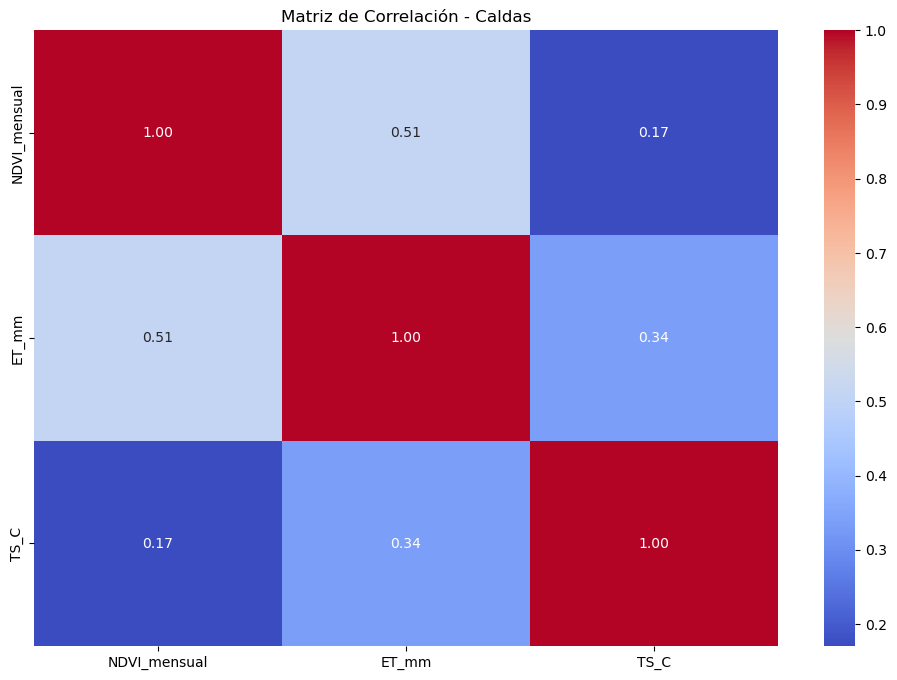

In [88]:
plt.figure(figsize=(12,8))
sns.heatmap(df_caldas_union.corr(numeric_only=True), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')
plt.title('Matriz de Correlación - Caldas')
plt.show()


In [89]:
corr_matrixS = df_sierra_union.corr(numeric_only=True).sort_values(by='ET_mm')
corr_matrixS

,NDVI_mensual,ET_mm,TS_C
TS_C,-0.701582,-0.716233,1.000000
NDVI_mensual,1.000000,0.861628,-0.701582
ET_mm,0.861628,1.000000,-0.716233


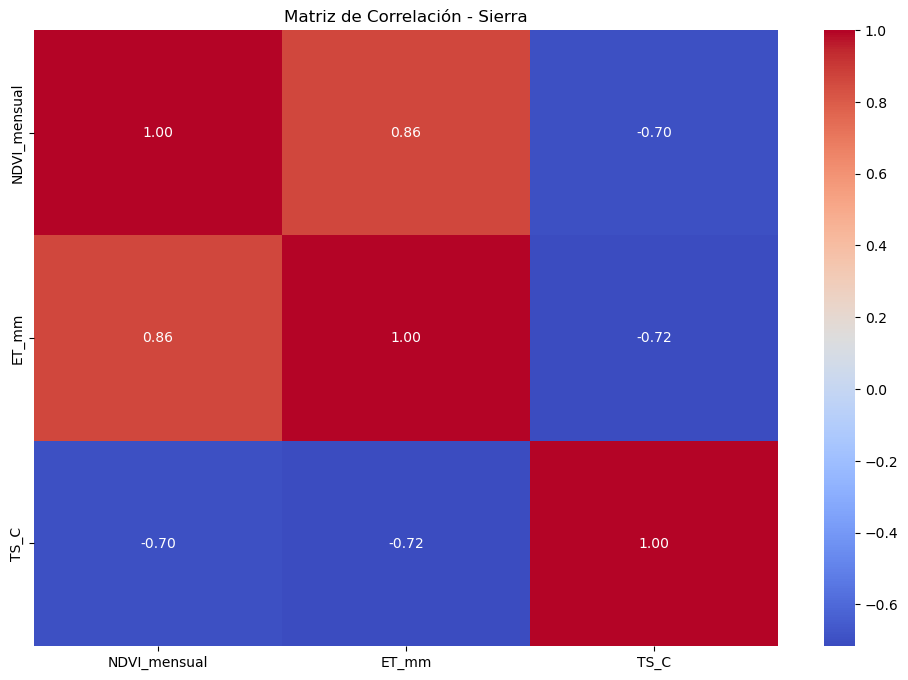

In [90]:
plt.figure(figsize=(12,8))
sns.heatmap(df_sierra_union.corr(numeric_only=True), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')
plt.title('Matriz de Correlación - Sierra')
plt.show()

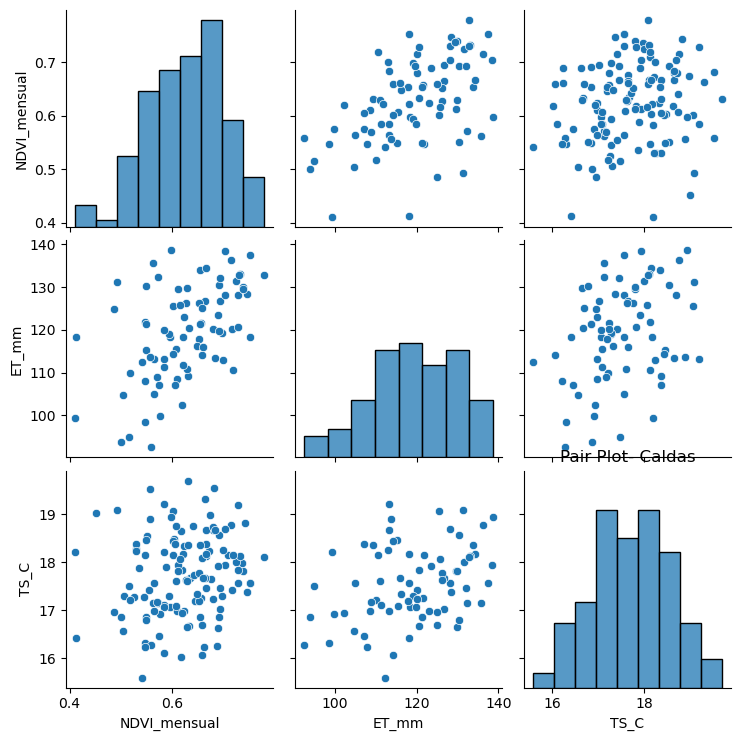

In [91]:
df_numC = df_caldas_union.select_dtypes(include='number')
sns.pairplot(df_numC)
plt.title('Pair Plot- Caldas')
plt.show()

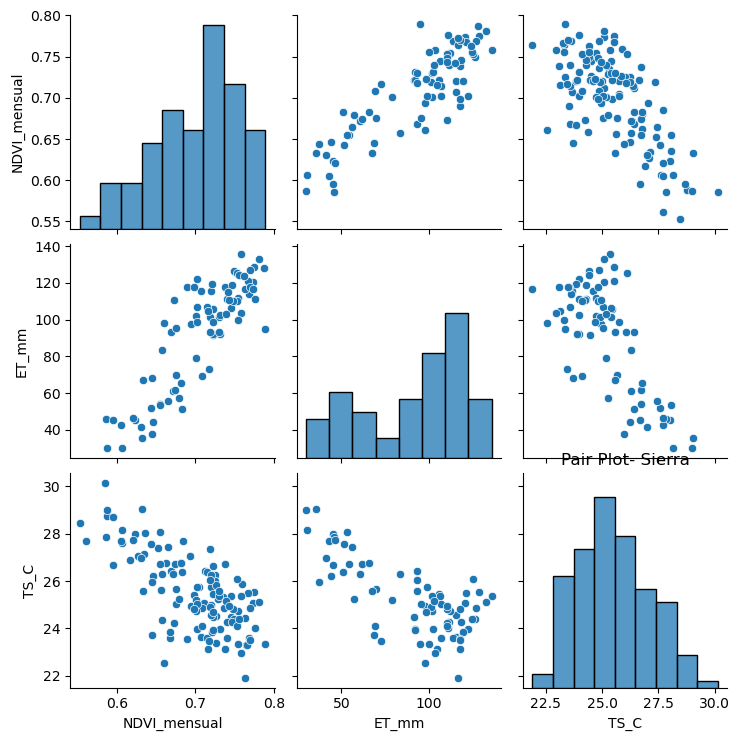

In [92]:
df_numS = df_sierra_union.select_dtypes(include='number')
sns.pairplot(df_numS)
plt.title('Pair Plot- Sierra')
plt.show()